# Braided Hair classifier 

**Help a friend to remeber the difference between 3 diffirent braid styles for black mens hair.**
- cornrows
- two strand twist
- dreadlocks

In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [2]:
# Using duckduckgo to search for images for our data #
# cornrows #

urls = search_images_ddg('cornrows men black', max_images=100)
len(urls),urls[0]

(100,
 'http://coolmenshair.com/wp-content/uploads/black-men-braid-styles-3.jpg')

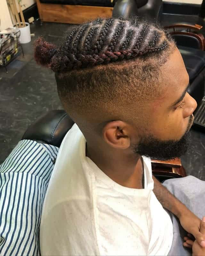

In [3]:
download_url(urls[0], 'images/cornrows men black.jpg')
im = Image.open('images/cornrows men black.jpg')
im.thumbnail((256,256))
im

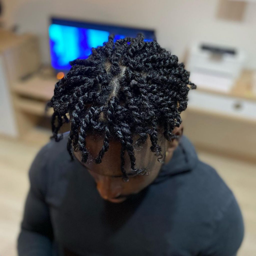

In [6]:
# two strand twist #
urls = search_images_ddg('two strand twist men black hair', max_images=50)
download_url(urls[0], 'images/two strand twist men black hair.jpg')
im = Image.open('images/two strand twist men black hair.jpg')
im.thumbnail((256,256))
im

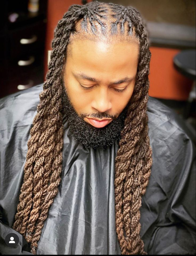

In [5]:
# dreadlocs #
urls = search_images_ddg('dreadlocs men black hair', max_images=50)
download_url(urls[0], 'images/dreadlocs men black hair.jpg')
im = Image.open('images/dreadlocs men black hair.jpg')
im.thumbnail((256,256))
im

In [16]:
# naming the folders and location where the files will be downloaded #
hair_types = 'cornrows men black', 'two strand twist men black', 'dreadlocs men black'
path = Path("hair2")

hair2 directory has 3 folders with 200 images respectivly. 200 is the max we can get with duckduckgo.

In [17]:
# Creating directories for images and downloading them #
if not path.exists():
    path.mkdir()
    for o in hair_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg( f'{o} hair')
        download_images(dest, urls=results)

In [18]:
# collecting images from the image path #
fns = get_image_files(path)
fns

(#584) [Path('hair2/dreadlocs men black/00000047.jpg'),Path('hair2/dreadlocs men black/00000199.jpg'),Path('hair2/dreadlocs men black/00000055.jpg'),Path('hair2/dreadlocs men black/00000154.jpg'),Path('hair2/dreadlocs men black/00000183.jpg'),Path('hair2/dreadlocs men black/00000159.jpg'),Path('hair2/dreadlocs men black/00000185.jpg'),Path('hair2/dreadlocs men black/00000107.jpg'),Path('hair2/dreadlocs men black/00000036.jpg'),Path('hair2/dreadlocs men black/00000030.jpg')...]

In [19]:
# check for damaged images # 
failed = verify_images(fns)
failed

(#3) [Path('hair2/dreadlocs men black/00000032.jpg'),Path('hair2/cornrows men black/00000175.jpg'),Path('hair2/cornrows men black/00000145.jpg')]

In [20]:
# Delete damaged images #
failed.map(Path.unlink);

In [21]:
# creating data block #
hair = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [22]:
# creating dataloaders #
dls = hair.dataloaders(path)

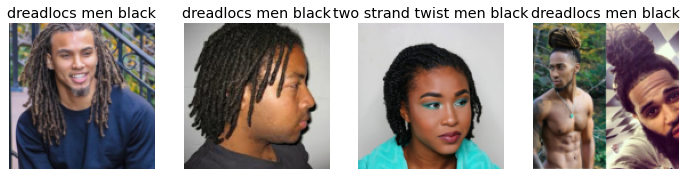

In [23]:
# show validation data #
dls.valid.show_batch(max_n=4, nrows=1)

From this we can see our images confuse women and men. will deal with it later.

In [24]:
# performing data augmentation #
hair = hair.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hair.dataloaders(path)

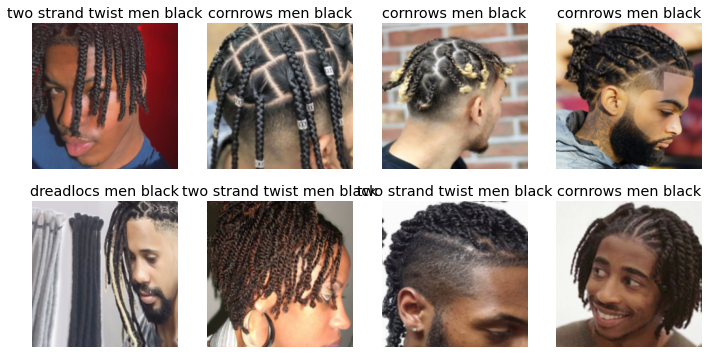

In [25]:
# show augmented train data #
dls.train.show_batch(max_n=8, nrows=2)

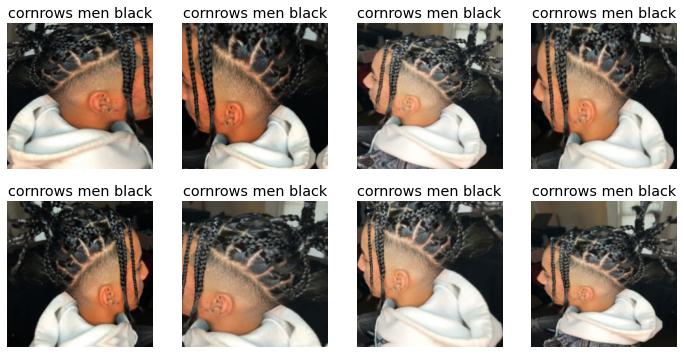

In [26]:
# show augmented train data unique #
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [27]:
# learner and fine tunning model using CNN resnet18. error_rate metric #
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.752426,1.174297,0.396552,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.033968,0.760111,0.318966,00:13
1,0.913734,0.691085,0.284483,00:12
2,0.810926,0.739782,0.310345,00:12
3,0.762318,0.748642,0.310345,00:13


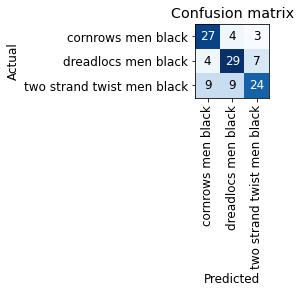

In [28]:
# Confussion matrix #
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The model accuracy is about 70%. this is expected since these hairstyles by design are very similar to the untraied eye.

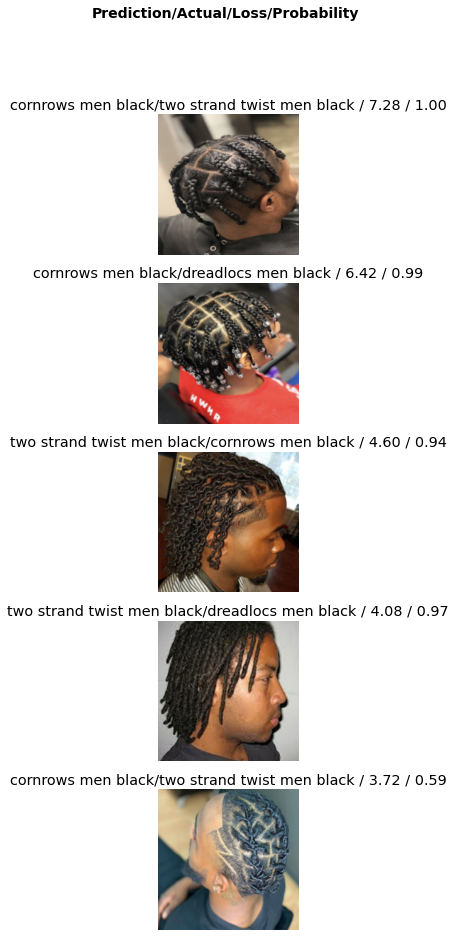

In [32]:
# show top losses #
interp.plot_top_losses(5, nrows=5)

In [33]:
# lets try clean the data #
cleaner = ImageClassifierCleaner(learn)
cleaner

In [36]:
# #hide
# # making changes to images #
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [37]:
# export model #
learn.export(fname="hair.pkl")

In [40]:
# show model location #
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('hair.pkl'),Path('export.pkl')]

model prediction

In [46]:
# reload model #
learn_inf = load_learner(path/'hair.pkl')

In [ ]:
# # make prediction #
# learn_inf.predict('images/some hair image.jpg')

In [ ]:
# # model vocab #
# learn_inf.dls.vocab

model prediction using GUI

In [41]:
# using a button #
btn_upload = widgets.FileUpload()

In [42]:
btn_run = widgets.Button(description='Classify')

In [44]:
lbl_pred = widgets.Label()

In [45]:
out_pl = widgets.Output()

In [47]:
# button event handler for Classify btn #
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [49]:
# creating vitual box to show predictions #
VBox([widgets.Label('Select your Hair style!'), 
      btn_upload, btn_run, out_pl, lbl_pred])